In [0]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [3]:
#reading dataset 
df=pd.read_csv("/content/data.csv")
df.head(5)

,Unnamed: 0,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,game_season,remaining_sec,distance_of_shot,is_goal,area_of_shot,shot_basics,range_of_shot,team_name,date_of_game,home/away,shot_id_number,lat/lng,type_of_shot,type_of_combined_shot,match_id,team_id,remaining_min.1,power_of_shot.1,knockout_match.1,remaining_sec.1,distance_of_shot.1
0,0,10.0,167.0,72.0,10.0,1.0,0.0,2000-01,27.0,38.0,NaN,Right Side(R),Mid Range,16-24 ft.,Manchester United,2000-10-31,MANU @ POR,1.0,"45.539131, -122.651648",shot - 30,NaN,20000012,1610612747,10.00,1.0,50.608,54.2000,38.0
1,1,12.0,-157.0,0.0,10.0,1.0,0.0,2000-01,22.0,35.0,0.0,Left Side(L),Mid Range,8-16 ft.,Manchester United,2000-10-31,MANU @ POR,2.0,"45.539131, -122.651648",shot - 45,NaN,20000012,1610612747,10.00,1.0,28.800,22.0000,35.0
2,2,35.0,-101.0,135.0,7.0,1.0,0.0,2000-01,45.0,36.0,1.0,Left Side Center(LC),Mid Range,16-24 ft.,Manchester United,2000-10-31,NaN,3.0,"45.539131, -122.651648",shot - 25,NaN,20000012,1610612747,92.64,1.0,0.000,63.7216,54.4
3,3,43.0,138.0,175.0,6.0,1.0,0.0,2000-01,52.0,42.0,0.0,Right Side Center(RC),Mid Range,16-24 ft.,Manchester United,2000-10-31,MANU @ POR,4.0,"45.539131, -122.651648",NaN,shot - 3,20000012,1610612747,NaN,1.0,122.608,52.0000,42.0
4,4,155.0,0.0,0.0,NaN,2.0,0.0,2000-01,19.0,20.0,1.0,Center(C),Goal Area,Less Than 8 ft.,NaN,2000-10-31,MANU @ POR,5.0,"45.539131, -122.651648",NaN,shot - 1,20000012,1610612747,42.64,2.0,0.000,19.0000,20.0


In [0]:
#removing some features
df=df.drop(['Unnamed: 0','team_name','team_id','date_of_game'],axis=1)

In [5]:
df.shape

(30697, 24)

In [0]:
#fill shot_id_number
shot_id_number=[i+1 for i in range(30697)]
df['shot_id_number']=shot_id_number

In [0]:
"""create training dataset"""
#select rows with non NAN values in is_goal column 
traindf = df[np.isfinite(df['is_goal'])]
X_train=traindf.loc[:, traindf.columns != 'is_goal']
y_train=traindf['is_goal']

In [38]:
#fill missing values
X_train=X_train.fillna(method='ffill')
X_train=X_train.fillna(method='bfill')
#check number of null values
print(X_train.isnull().sum().sum())

0


In [0]:
#taking average of power_of_shot and power_of_shot.1
X_train['power_of_shot']=(X_train['power_of_shot']+X_train['power_of_shot.1'])/2

#taking average of remaining_min and remaining_min.1
X_train['remaining_min']=(X_train['remaining_min']+X_train['remaining_min.1'])/2

#taking average of remaining_sec and remaining_sec.1 and converting to minutes and adding to remaining_min
X_train['remaining_min']=X_train['remaining_min']+(X_train['remaining_sec']+X_train['remaining_sec.1'])/120

#taking average of distance_of_shot and distance_of_shot.1 
X_train['distance_of_shot']=(X_train['distance_of_shot']+X_train['distance_of_shot.1'])/2

#taking average of knockout_match and knockout_match.1
X_train['knockout_match']=(X_train['knockout_match']+X_train['knockout_match.1'])/2

#removing extra columns
X_train=X_train.drop(['knockout_match.1','power_of_shot.1','remaining_min.1','remaining_sec.1','remaining_sec','distance_of_shot.1'],axis=1)

In [0]:
#converting categorical features to numerical values using label encoder
le=LabelEncoder()
X_train['area_of_shot']=le.fit_transform(X_train['area_of_shot'])
X_train['shot_basics']=le.fit_transform(X_train['shot_basics'])
X_train['range_of_shot']=le.fit_transform(X_train['range_of_shot'])
X_train['home/away']=le.fit_transform(X_train['home/away'])
X_train['game_season']=le.fit_transform(X_train['game_season'])
X_train['type_of_shot']=le.fit_transform(X_train['type_of_shot'])
X_train['type_of_combined_shot']=le.fit_transform(X_train['type_of_combined_shot'])

In [0]:
#splitting lat/lng column into seperate columns
res=X_train["lat/lng"].str.split(",", n = 1, expand = True)
X_train["lat"]=res.iloc[:,0]
X_train["lng"]=res.iloc[:,1]
X_train['lat']=pd.to_numeric(X_train['lat'])
X_train['lng']=pd.to_numeric(X_train['lng'])

#dropping lat/lng column after splitting
X_train=X_train.drop(['lat/lng'],axis=1)

In [0]:
"""create test dataset"""

#select rows with NAN values is_goal column
testdf=df[df['is_goal'].isnull()]
X_test=testdf.loc[:, testdf.columns != 'is_goal']
y_test=testdf['is_goal']

In [13]:
#fill missing values
X_test=X_test.fillna(method='ffill')
X_test=X_test.fillna(method='bfill')
#check number of null values
X_test.isnull().sum().sum()

0

In [0]:
#following steps are similar done during training
X_test['power_of_shot']=(X_test['power_of_shot']+X_test['power_of_shot.1'])/2
X_test['remaining_min']=(X_test['remaining_min']+X_test['remaining_min.1'])/2
X_test['remaining_min']=X_test['remaining_min']+(X_test['remaining_sec']+X_test['remaining_sec.1'])/120
X_test['distance_of_shot']=(X_test['distance_of_shot']+X_test['distance_of_shot.1'])/2
X_test['knockout_match']=(X_test['knockout_match']+X_test['knockout_match.1'])/2

#removing extra columns
X_test=X_test.drop(['knockout_match.1','power_of_shot.1','remaining_min.1','remaining_sec.1','remaining_sec','distance_of_shot.1'],axis=1)

In [0]:
#converting categorical features to numerical values using label encoder
le=LabelEncoder()
X_test['area_of_shot']=le.fit_transform(X_test['area_of_shot'])
X_test['shot_basics']=le.fit_transform(X_test['shot_basics'])
X_test['range_of_shot']=le.fit_transform(X_test['range_of_shot'])
X_test['home/away']=le.fit_transform(X_test['home/away'])
X_test['game_season']=le.fit_transform(X_test['game_season'])
X_test['type_of_shot']=le.fit_transform(X_test['type_of_shot'])
X_test['type_of_combined_shot']=le.fit_transform(X_test['type_of_combined_shot'])

In [0]:
#split lat/lng columns into seperate columns
res=X_test["lat/lng"].str.split(",", n = 1, expand = True)
X_test["lat"]=res.iloc[:,0]
X_test["lng"]=res.iloc[:,1]
X_test['lat']=pd.to_numeric(X_test['lat'])
X_test['lng']=pd.to_numeric(X_test['lng'])

#dropping lat/lng column after splitting
X_test=X_test.drop(['lat/lng'],axis=1)

In [17]:
X_test.head(5)

,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,game_season,distance_of_shot,area_of_shot,shot_basics,range_of_shot,home/away,shot_id_number,type_of_shot,type_of_combined_shot,match_id,lat,lng
0,10.0,167.0,72.0,10.676667,1.00,25.304,4,38.0,5,4,0,28,1,24,3,20000012,45.539131,-122.651648
7,254.0,1.0,28.0,38.403333,3.00,0.000,4,22.0,0,0,4,28,8,24,3,20000012,45.539131,-122.651648
16,100.0,0.0,0.0,0.016667,1.00,0.000,4,20.0,0,0,4,71,17,24,4,20000019,42.982923,-71.446094
19,249.0,0.0,0.0,10.766667,36.68,0.000,4,20.0,0,0,4,71,20,34,4,20000019,42.982923,-71.446094
21,265.0,134.0,127.0,9.066667,23.18,0.000,4,38.0,4,4,0,71,22,17,4,20000019,42.982923,-71.446094


In [42]:
X_train.head(5)

,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,game_season,distance_of_shot,area_of_shot,shot_basics,range_of_shot,home/away,shot_id_number,type_of_shot,type_of_combined_shot,match_id,lat,lng
1,12.0,-157.0,0.0,10.366667,1.0,14.400,4,35.0,2,4,2,28,2,40,3,20000012,45.539131,-122.651648
2,35.0,-101.0,135.0,50.726013,1.0,0.000,4,45.2,1,4,0,28,3,18,3,20000012,45.539131,-122.651648
3,43.0,138.0,175.0,50.186667,1.0,61.304,4,42.0,4,4,0,28,4,18,3,20000012,45.539131,-122.651648
4,155.0,0.0,0.0,24.636667,2.0,0.000,4,20.0,0,0,4,28,5,18,1,20000012,45.539131,-122.651648
5,244.0,-145.0,-11.0,9.425000,3.0,0.000,4,34.0,2,4,2,28,6,9,1,20000012,45.539131,-122.651648


**Exploratory Data Analysis**

In [0]:
Xtemp=traindf.copy(deep=True)
Xtemp=Xtemp.fillna(method='ffill')
Xtemp=Xtemp.fillna(method='bfill')

In [83]:
Xtemp[Xtemp['is_goal']==1]['area_of_shot'].value_counts()

Center(C)                5578
Right Side(R)            1467
Right Side Center(RC)    1455
Left Side Center(LC)     1195
Left Side(L)             1180
Mid Ground(MG)              4
Name: area_of_shot, dtype: int64

In [84]:
Xtemp[Xtemp['is_goal']==1]['range_of_shot'].value_counts()

Less Than 8 ft.    4237
16-24 ft.          2630
8-16 ft.           2327
24+ ft.            1679
Back Court Shot       6
Name: range_of_shot, dtype: int64

In [85]:
Xtemp[Xtemp['is_goal']==1]['shot_basics'].value_counts()

Mid Range          4043
Goal Area          3430
Goal Line          1686
Penalty Spot       1521
Right Corner        110
Left Corner          85
Mid Ground Line       4
Name: shot_basics, dtype: int64

In [86]:
Xtemp[Xtemp['is_goal']==1]['type_of_combined_shot'].value_counts()

shot - 3    7801
shot - 4    2242
shot - 1     659
shot - 2      62
shot - 0      62
shot - 5      53
Name: type_of_combined_shot, dtype: int64

In [76]:
Xtemp[Xtemp['is_goal']==1]['type_of_shot'].value_counts()

shot - 4     967
shot - 39    935
shot - 36    812
shot - 15    553
shot - 44    528
shot - 38    457
shot - 12    330
shot - 17    327
shot - 43    297
shot - 32    282
shot - 52    280
shot - 46    236
shot - 56    234
shot - 31    174
shot - 10    156
shot - 1     153
shot - 49    138
shot - 27    138
shot - 26    136
shot - 55    130
shot - 24    129
shot - 3     125
shot - 8     124
shot - 18    122
shot - 19    120
shot - 48    115
shot - 21    114
shot - 16    113
shot - 5     113
shot - 51    110
shot - 53    110
shot - 54    110
shot - 29    106
shot - 14    102
shot - 13    101
shot - 42    101
shot - 11     99
shot - 22     98
shot - 45     95
shot - 2      94
shot - 20     91
shot - 6      90
shot - 9      89
shot - 23     89
shot - 37     88
shot - 40     86
shot - 50     85
shot - 28     85
shot - 30     84
shot - 35     84
shot - 7      82
shot - 41     81
shot - 33     79
shot - 0      78
shot - 47     76
shot - 34     74
shot - 25     74
Name: type_of_shot, dtype: int6

In [0]:
Xtemp['home_away']=Xtemp['home/away'].str.replace("@", "vs.", case = False)

In [89]:
Xtemp[Xtemp['is_goal']==1]['home_away'].value_counts()

MANU vs. SAS    671
MANU vs. PHX    657
MANU vs. SAC    617
MANU vs. DEN    588
MANU vs. HOU    584
MANU vs. POR    573
MANU vs. MIN    513
MANU vs. UTA    508
MANU vs. GSW    492
MANU vs. LAC    461
MANU vs. DAL    446
MANU vs. MEM    375
MANU vs. BOS    306
MANU vs. SEA    298
MANU vs. PHI    260
MANU vs. NYK    255
MANU vs. DET    246
MANU vs. ORL    246
MANU vs. TOR    241
MANU vs. IND    237
MANU vs. OKC    223
MANU vs. MIA    216
MANU vs. CLE    213
MANU vs. CHI    213
MANU vs. NOH    207
MANU vs. WAS    203
MANU vs. MIL    199
MANU vs. ATL    193
MANU vs. NJN    175
MANU vs. CHA    157
MANU vs. VAN     91
MANU vs. NOK     83
MANU vs. CHH     51
MANU vs. NOP     30
MANU vs. PHO     19
MANU vs. BKN     18
MANU vs. SAN      7
MANU vs. UTH      7
Name: home_away, dtype: int64

In [92]:
# goal stats
Xtemp=X_train
Xtemp['is_goal']=y_train
Xtemp=Xtemp[Xtemp['is_goal']==1]
Xtemp.describe()

,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,game_season,distance_of_shot,area_of_shot,shot_basics,range_of_shot,home/away,shot_id_number,type_of_shot,type_of_combined_shot,match_id,lat,lng,is_goal
count,10879.000000,10879.000000,10879.000000,10879.000000,10879.000000,10879.000000,10879.000000,10879.000000,10879.000000,10879.000000,10879.000000,10879.000000,10879.000000,10879.000000,10879.000000,1.087900e+04,10879.000000,10879.000000,10879.0
mean,242.643625,6.677636,78.041824,12.305758,9.199491,8.303818,9.330545,34.365756,1.537090,2.417961,2.141649,37.160677,15204.332383,28.442320,3.071882,2.474171e+07,40.322543,-85.279645,1.0
std,148.821665,101.033093,81.389525,15.045552,14.875945,17.485232,4.761950,12.079670,1.922443,2.036858,1.630929,21.062028,8879.244428,14.747852,0.720934,7.740298e+06,4.847380,18.081098,0.0
min,2.000000,-250.000000,-44.000000,0.000000,1.000000,0.000000,0.000000,14.700000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,2.000001e+07,25.790710,-123.114646,1.0
25%,104.000000,-42.000000,0.000000,3.433333,2.000000,0.000000,5.000000,23.000000,0.000000,0.000000,1.000000,17.000000,7589.500000,16.000000,3.000000,2.050004e+07,38.567296,-96.786653,1.0
50%,247.000000,0.000000,53.000000,6.766667,3.000000,0.000000,9.000000,34.000000,0.000000,4.000000,2.000000,36.000000,15034.000000,32.000000,3.000000,2.090010e+07,42.982923,-71.446094,1.0
75%,357.000000,75.000000,146.000000,11.082440,4.000000,1.000000,13.000000,41.000000,4.000000,4.000000,4.000000,54.000000,23015.000000,39.000000,3.000000,2.960046e+07,42.982923,-71.446094,1.0
max,650.000000,248.000000,432.000000,69.047467,61.180000,70.676160,19.000000,79.864000,5.000000,6.000000,4.000000,73.000000,30695.000000,56.000000,5.000000,4.990009e+07,49.250068,-71.074655,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f084fa65ef0>,
      dtype=object)

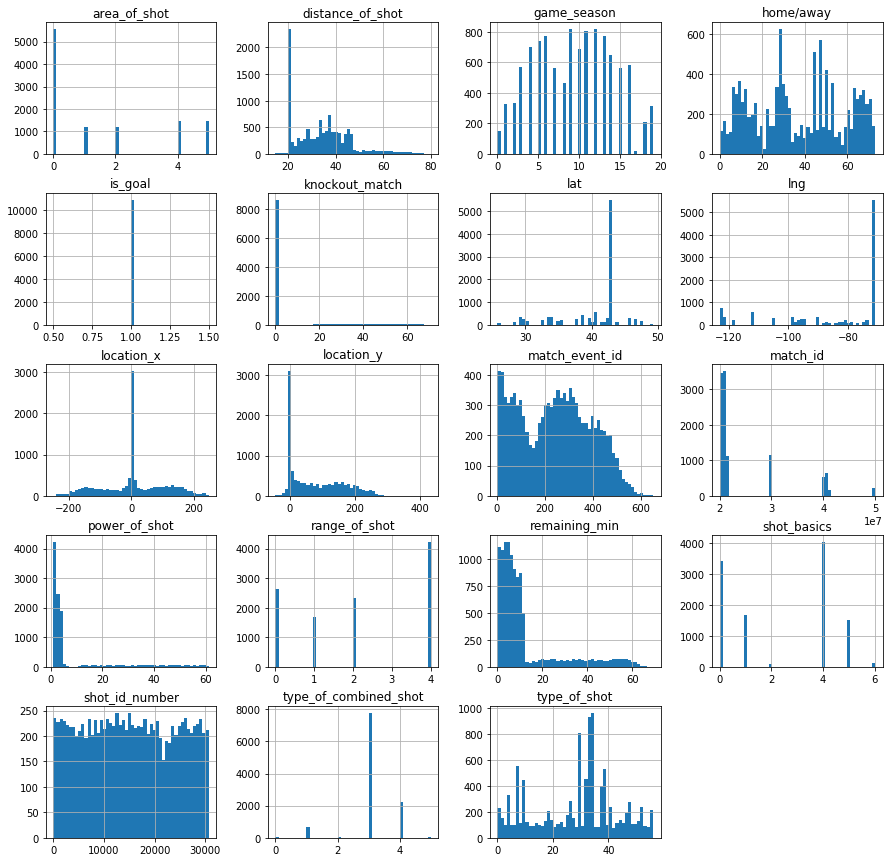

In [94]:
# histogram analysis
Xtemp.hist(bins=50,figsize=(15,15))

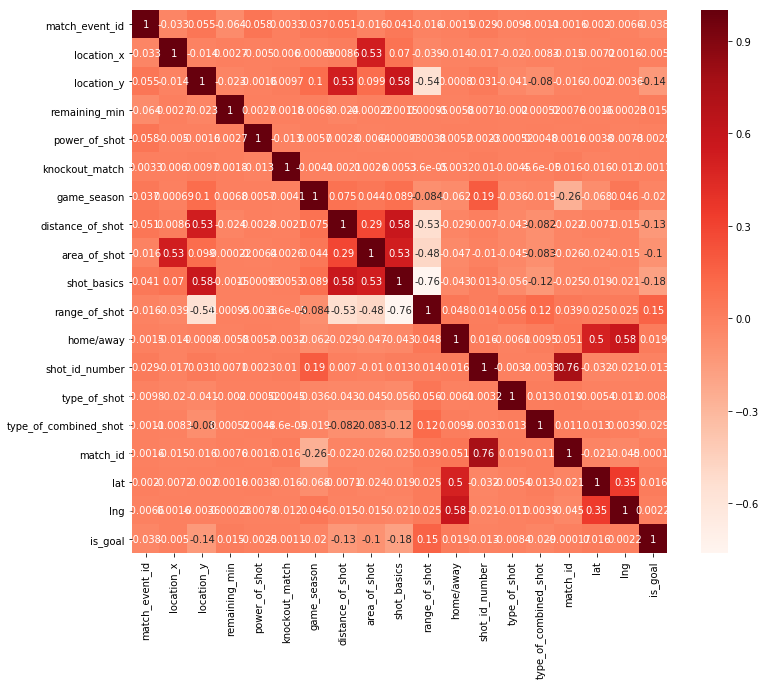

In [0]:
"""Plotting Heat Map to check correlation among features"""
test=pd.DataFrame(X_train)
test['is_goal']=y_train

#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = test.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [0]:
#Correlation with output variable
cor_target = abs(cor["is_goal"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.05]
relevant_features

location_y          0.138639
distance_of_shot    0.131622
area_of_shot        0.099923
shot_basics         0.178399
range_of_shot       0.152113
is_goal             1.000000
Name: is_goal, dtype: float64

In [0]:
#selecting relevant features from training and testing dataset
Xtrain=X_train[['location_y','distance_of_shot','shot_basics','area_of_shot','range_of_shot']]
Xtest=X_test[['location_y','distance_of_shot','shot_basics','area_of_shot','range_of_shot']]

In [0]:
#scaling features
scaler = StandardScaler()
Xtrain=scaler.fit_transform(Xtrain)
Xtest=scaler.fit_transform(Xtest)

In [24]:
Xscaled=pd.DataFrame(Xtrain,columns=['location_y','distance_of_shot','shot_basics','area_of_shot','range_of_shot'])
Xscaled.head(5)

,location_y,distance_of_shot,shot_basics,area_of_shot,range_of_shot
0,-1.040308,-0.093521,0.599964,0.126000,0.079904
1,0.491610,0.764840,0.599964,-0.387095,-1.188847
2,0.945512,0.495550,0.599964,1.152191,-1.188847
3,-1.040308,-1.355816,-1.420370,-0.900190,1.348654
4,-1.165131,-0.177674,0.599964,0.126000,0.079904


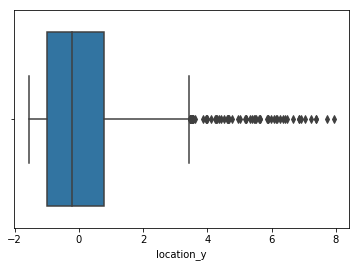

In [25]:
sns.boxplot(x=Xscaled['location_y'])

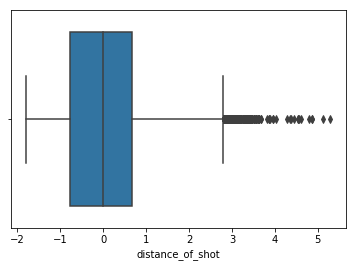

In [26]:
sns.boxplot(x=Xscaled['distance_of_shot'])

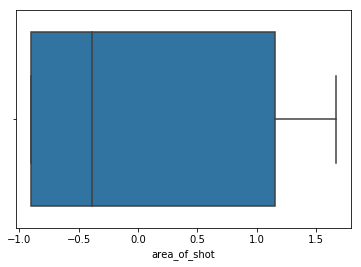

In [27]:
sns.boxplot(x=Xscaled['area_of_shot'])

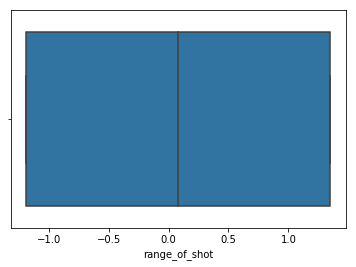

In [28]:
sns.boxplot(x=Xscaled['range_of_shot'])

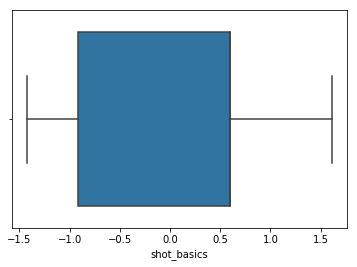

In [29]:
sns.boxplot(x=Xscaled['shot_basics'])

**Logistic Regression**

In [0]:

# lr = LogisticRegression(random_state=0,max_iter=100)
# lr.fit(Xtrain, y_train)
# y_pred=lr.predict(Xtest)
# final=[]
# for i in y_pred:
#   final.append(i[1])
# result = pd.DataFrame(X_test['shot_id_number'], columns = ['shot_id_number']) 
# result["is_goal"]=final
# sample=pd.read_csv("/content/sample_submission.csv")
# result=pd.merge(sample['shot_id_number'], result, on='shot_id_number')
# result.to_csv("/content/result_LR.csv",index=False)

In [0]:
# result.shape

(5000, 2)

**SVM**

In [0]:
# Hyperparameter Tuning
svm = SVC()
parameters = {'C':(1,0.25,0.5,0.75)}
clf = GridSearchCV(svm, parameters,verbose=10,n_jobs=4)
clf.fit(Xtrain,y_train)
clf.best_params_

In [0]:
# Fitting Model
svmmodel=SVC(C=0.5,random_state=0,probability=True,verbose=10)
svmmodel.fit(Xtrain,y_train)

[LibSVM]

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=0, shrinking=True,
    tol=0.001, verbose=10)

In [0]:
#predict probabilities
y_pred=svmmodel.predict_proba(Xtest)
y_pred

array([[0.6080214 , 0.3919786 ],
       [0.40097622, 0.59902378],
       [0.38592005, 0.61407995],
       ...,
       [0.58637865, 0.41362135],
       [0.61033693, 0.38966307],
       [0.38592005, 0.61407995]])

In [0]:
# save result to csv file
final=[]
for i in y_pred:
  final.append(i[1])
result = pd.DataFrame(X_test['shot_id_number'], columns = ['shot_id_number']) 
result["is_goal"]=final
sample=pd.read_csv("/content/sample_submission.csv")
result=pd.merge(sample['shot_id_number'], result, on='shot_id_number')
result.to_csv("/content/result_SVM.csv",index=False)

**Nueral Network**

In [0]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(activation='logistic',learning_rate='adaptive',max_iter=5000,hidden_layer_sizes=(2), random_state=1,verbose=10).fit(Xtrain,y_train)


In [0]:
predict probabilities
y_pred=clf.predict_proba(Xtest)

In [0]:
#save result to csv file
final=[]
for i in y_pred:
  final.append(i[1])
result = pd.DataFrame(X_test['shot_id_number'], columns = ['shot_id_number']) 
result["is_goal"]=final
sample=pd.read_csv("/content/sample_submission.csv")
result=pd.merge(sample['shot_id_number'], result, on='shot_id_number')
result.to_csv("/content/result_MLP.csv",index=False)

**LDA**

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()


**Ensemble**

In [0]:
#votingclassfier used for ensembling
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

random_forest = RandomForestClassifier()
knn=KNeighborsClassifier()
gnb = GaussianNB()

In [0]:
eclf1 = VotingClassifier(estimators=[('rf', random_forest), ('knn', knn), ('gnb', gnb),('svm',svmmodel),('lr',lr),('lda',lda)], voting='soft')
eclf1 = eclf1.fit(Xtrain,y_train)

In [0]:
y_pred=eclf1.predict_proba(Xtest)
final=[]
for i in y_pred:
  final.append(i[1])
result = pd.DataFrame(X_test['shot_id_number'], columns = ['shot_id_number']) 
result["is_goal"]=final
sample=pd.read_csv("/content/sample_submission.csv")
result=pd.merge(sample['shot_id_number'], result, on='shot_id_number')
result.to_csv("/content/result_vc.csv",index=False)

In [0]:
"""array([[0.6080214 , 0.3919786 ],
       [0.40097622, 0.59902378],
       [0.38592005, 0.61407995],
       ...,
       [0.58637865, 0.41362135],
       [0.61033693, 0.38966307],
       [0.38592005, 0.61407995]])"""